## Assignment 5

This assignment is designed to help you understand, implement, and get hold of two important models in Multi-Modal Learning: CLIP and BLIP.

Before starting to code, read the instructions and comments carefully. Make sure you understand the requirements and the expected output.

There are two parts of this assignment.
- Content based image retrieval (CBIR) based on CLIP
- Visual Question Answering (VQA) based on BLIP

## Part 1: Content Based Image Retrieval (CBIR)

Ever found yourself looking for a specific image in a load of photos on your phone?
Imagine you have a system that can retrieve images based on their content. In this assignment, you will implement exactly that.

### Task
1. I have provided a list of images in form of unsplash links. Feel free to explore and add more images.
2. You will have to implement CBIR system that will retrive images based on the query you provide.
3. You have to use CLIP model to extract image and text embeddings. Since CLIP projects both image and text into the same embedding space, similar images and their corresponding text descriptions will be close to each other in the embedding space.
4. You have to use a pretrained CLIP model from HuggingFace. (Because it is not feasible to train CLIP from scratch)
5. You have to use [OpenAI's CLIP](https://huggingface.co/openai/clip-vit-base-patch32) model from HuggingFace. Refer to the page itself and anyother resources you find useful, on how to use it.
6. You will have to take an input query from user, and display the best image matching the query. (You can use cosine similarity to find similarity between the query and the images, then display the image with highest similarity score)

##### Load all the libraries

In [109]:
## Load libraries
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from scipy.spatial.distance import cosine
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

IMAGE_URLS = [
    "https://images.unsplash.com/photo-1750126833705-ba98013f16f3",
    "https://images.unsplash.com/photo-1749627995669-4d4dda3a9c1d",
    "https://images.unsplash.com/photo-1744294724362-3f5c404c771a",
    "https://images.unsplash.com/photo-1750075750236-3f8924fc0e35"

]
# Feel free to edit the above list with your own image URLs

##### Load the CLIP model

In [110]:
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

##### Loop through images, convert then to tensors, and store them in a list

In [111]:
image_tensors = []

for url in IMAGE_URLS:
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")

    inputs = processor(images=img, return_tensors="pt")
    image_tensor = inputs["pixel_values"]
    image_tensors.append(image_tensor)

##### Get the embeddings for the images and store them in a list
Use the CLIP model linked above, the page also provides details on how to use it. If you have any issues with it, feel free to use anyother resources you find useful.

In [112]:
images = []
image_embeddings = []

for url in IMAGE_URLS:

    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    images.append(img)

    inputs = processor(images=img, return_tensors="pt")
    with torch.no_grad():
        img_emb = model.get_image_features(**inputs)

    image_embeddings.append(img_emb.cpu().numpy()[0])

image_embeddings = np.array(image_embeddings)

print(f"Extracted embeddings for {len(images)} images!")

Extracted embeddings for 4 images!


##### Get the query from user

In [113]:
query = input("Enter which image are you looking for: ")

Enter which image are you looking for: car


##### Get the embeddings for the user query

In [114]:
text_inputs = processor(
    text=query,
    return_tensors="pt",
    truncation=True,
    padding=True
)

with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

##### Find the similarity between the query and all the images

In [115]:
image_embeddings = torch.tensor(image_embeddings)
similarities = (image_embeddings @ text_features.T).squeeze()

best_idx = similarities.argmax().item()

print(f"Similarity scores: {similarities}")
print(f"Best match index: {best_idx}")



✅ Similarity scores: tensor([1.9982, 2.0624, 2.1312, 2.4932])
🏆 Best match index: 3


##### Display the image with highest similarity score

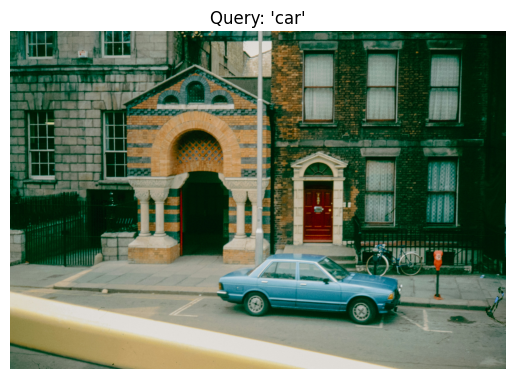

In [116]:
plt.imshow(images[best_idx])
plt.axis('off')
plt.title(f"Query: '{query}'")
plt.show()

Congrats! You have implemented a simple Content Based Image Retrieval (CBIR) system using CLIP model.

Moving on to the next part of the assignment.

## Part 2: Visual Question Answering (VQA)

This part is based on Visual Question Answering (VQA), where you will be given an image and a question about that image, and you will need to provide an answer.

You are provided with a dataset of 10 images, and a json file containing questions and answers for those images.

### Format of JSON file
```json
[
    "what is the blue shape?",
    "rectangle",
    0
]
```
This means that the question is "what is the blue shape?", the answer is "rectangle", and the image index is 0.
Images are named from 0 to 9, so the image for index 0 is `0.png`.

### Task
1. Load the JSON file and parse the questions and answers.
2. Just for understanding, print a few questions and their corresponding answers, also display the corresponding images. (You may do it for 1 or 2 questions)
3. Implement a function that takes an image and a question, and returns the answer.
4. Run the function on all questions and store the answers in a file. (You can store it in a new JSON or CSV file) (May use pandas for this)
5. Now since you have the answers, you can also evaluate your model. For this, you can compare your answers with the ground truth answers provided in the JSON file. (refer to note below)

Note: But it is not that easy to compare directly, as the answers may not match exactly due to variations in phrasing ("2" and "two", "blue" and "The color is blue". Phrases like this don't match, but are correct). So you should check your answers manually and see if they are correct or not. Do it for first 30 answers, and calculate the accuracy.
There are certain ways to automate this, but they will make this assignment too complicated, so we will not do that here.

### Additional Points
- Refer to BLIP model that was taught in last class. It can be used to answer questions based on images.
- You will have to use pre-trained BLIP model for this task. (Because training it from scratch is not feasible in this assignment)
- You have to use [Salesforce BLIP model](https://huggingface.co/Salesforce/blip-vqa-base) for this task. Refer to the Usage section of page for details on how to use it. If you feel stuck, you can refer to blogs available online, or use AI tools to get yourself familiar with the model.

1. Load libraries, and the JSON file.

In [117]:

import json
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

json_path = "filtered_questions.json"
with open(json_path, "r") as f:
    data = json.load(f)



2. Display a few questions and answers along with images.

Q1: what is the blue shape?
Ground Truth Answer: rectangle


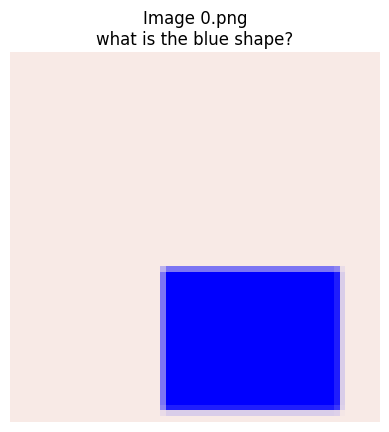

Q2: what color is the shape?
Ground Truth Answer: blue


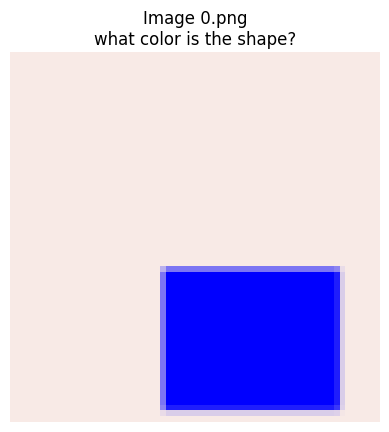

Q3: does the image contain a rectangle?
Ground Truth Answer: yes


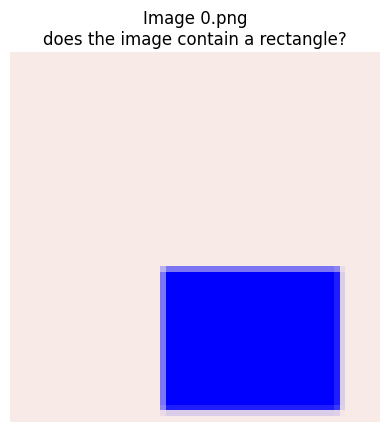

Q4: is there a triangle in the image?
Ground Truth Answer: no


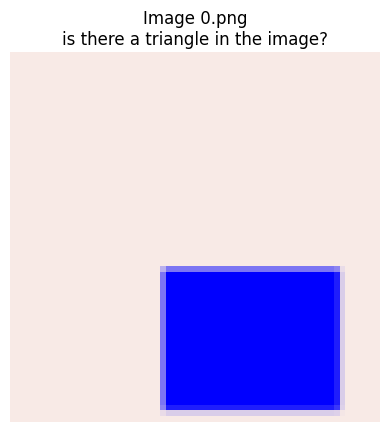

In [132]:
for i in range(4):
    question, answer, img_idx = data[i]
    print(f"Q{i+1}: {question}")
    print(f"Ground Truth Answer: {answer}")

    img = Image.open(f"{img_idx}.png").convert('RGB')
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {img_idx}.png\n{question}")
    plt.show()

3. Implement the function to answer questions based on images.

In [119]:
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)

def vqa(question, image):
    if isinstance(image, str):
        image = Image.open(image).convert('RGB')
    elif isinstance(image, Image.Image):
        image = image.convert('RGB')
    else:
        raise ValueError("image must be a file path or PIL Image")

    inputs = processor(images=image, text=question, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = model.generate(**inputs)
    answer = processor.decode(output_ids[0], skip_special_tokens=True)

    return answer

4. Run the function on all questions and store the answers in a file.

In [120]:
import pandas as pd

results = []
for question, ground_truth, img_idx in data:
    image_path = f"{img_idx}.png"
    predicted_answer = vqa(question, image_path)
    results.append(
        {
            "image_index": img_idx,
            "question": question,
            "ground_truth": ground_truth,
            "predicted": predicted_answer
        }
    )
    print(f"✅ [{img_idx}] {question} → {predicted_answer}")

df = pd.DataFrame(results)
df.to_csv("vqa_predictions.csv", index=False)

print("\n💾 Saved results to vqa_predictions.csv!")

✅ [0] what is the blue shape? → rectangle
✅ [0] what color is the shape? → black
✅ [0] does the image contain a rectangle? → yes
✅ [0] is there a triangle in the image? → no
✅ [0] is there a black shape? → yes
✅ [0] does the image not contain a gray shape? → yes
✅ [0] is there a red shape in the image? → no
✅ [0] does the image not contain a red shape? → yes
✅ [0] is there not a blue shape? → yes
✅ [0] is there not a blue shape in the image? → yes
✅ [0] is there not a yellow shape? → yes
✅ [0] is a teal shape present? → yes
✅ [1] what color is the triangle? → blue
✅ [1] what color is the shape? → blue
✅ [1] is there not a rectangle in the image? → yes
✅ [1] is there a red shape? → no
✅ [1] is there a green shape in the image? → no
✅ [1] is there not a teal shape? → yes
✅ [2] what shape is in the image? → triangle
✅ [2] what shape does the image contain? → triangle
✅ [2] what color is the triangle? → red
✅ [2] what is the color of the triangle? → red
✅ [2] is there a circle? → no
✅ [2] 

5. Evaluate the model by comparing answers with ground truth.
Do the comparison manually for the first 30 answers and print the accuracy.

In [127]:
import pandas as pd

df = pd.read_csv("vqa_predictions.csv")

num_to_check = 30
sample_df = df.sample(n=num_to_check, random_state=42)

manual_scores = []

for i, row in sample_df.iterrows():
    q = row['question']
    gt = row['ground_truth']
    pred = row['predicted']
    img_idx = row['image_index']

    print(f"\n{img_idx}. {q}\nGround Truth: {gt}\nPredicted: {pred}")
    score = input("✅ Correct? Enter 1 for yes, 0 for no: ")
    manual_scores.append(int(score))

accuracy = sum(manual_scores) / num_to_check * 100
print(f"\n📊 Manual Accuracy on {num_to_check} random questions: {accuracy:.2f}%")


3. what is the color of the rectangle?
Ground Truth: brown
Predicted: red
✅ Correct? Enter 1 for yes, 0 for no: 0

6. is there not a triangle in the image?
Ground Truth: yes
Predicted: yes
✅ Correct? Enter 1 for yes, 0 for no: 1

6. what is the color of the circle?
Ground Truth: red
Predicted: red
✅ Correct? Enter 1 for yes, 0 for no: 1

4. does the image contain a yellow shape?
Ground Truth: no
Predicted: no
✅ Correct? Enter 1 for yes, 0 for no: 0

4. is a circle present?
Ground Truth: yes
Predicted: yes
✅ Correct? Enter 1 for yes, 0 for no: 1

4. what is the color of the shape?
Ground Truth: red
Predicted: red
✅ Correct? Enter 1 for yes, 0 for no: 1

8. is there a brown shape in the image?
Ground Truth: yes
Predicted: no
✅ Correct? Enter 1 for yes, 0 for no: 0

4. is there not a gray shape?
Ground Truth: yes
Predicted: yes
✅ Correct? Enter 1 for yes, 0 for no: 1

0. is there not a yellow shape?
Ground Truth: yes
Predicted: yes
✅ Correct? Enter 1 for yes, 0 for no: 1

0. what is the 

Bonus: This images were too simple. But guess what? Salesforce has pretrained it's model on wide variety of images, so you can use it on any image of your choice.

Try to load any real world image of any natural scene, or anything you like, and ask questions about it. You will be surprised by the results.

In [133]:
image = Image.open('image_99.jpg').convert('RGB')
image.show()

print(vqa("what is in the image?", image))
print(vqa("what color is the sky?", image))
print(vqa("is there a person in the image?", image))
print(vqa("is it daytime or nighttime?", image))

mountains
blue
no
daytime


The End 🫡.

If you have any questions, feel free to use following in the given order:
- Google it!!
- ChatGPT
- Ask on the group